In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchdiffeq import odeint
from model import MLP
from torch.utils.data import DataLoader, TensorDataset
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load the dataset
t = torch.load("./data/t.pth")
X = torch.load("./data/X_Faultline038065.pth")

In [4]:
sample_index_d = range(0, X.shape[0], 50)
sample_index_t = range(0, len(t), 5)

In [5]:
# Training data
def getTrainingData():
    X_s = X[:, sample_index_t, :]
    t_s = t[sample_index_t]
    X_train = torch.tensor([])
    dX_train = torch.tensor([])
    for i in sample_index_d:
        x_train = X_s[i]
        dt = t_s - t_s[0]
        dx_train = np.gradient(x_train, dt, axis=0)
        dx_train = torch.Tensor(dx_train)
        X_train = torch.cat((X_train, x_train), 0)
        dX_train = torch.cat((dX_train, dx_train), 0)
    return t_s, X_train, dX_train

# Build dataset

# Training

In [6]:
t_eval, X_train, y_train= getTrainingData()
X_train.shape, X_train.shape

(torch.Size([1810, 38]), torch.Size([1810, 38]))

In [7]:
model = MLP(X_train.shape[1],1000,X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_train = X_train.to(device)
y_train = y_train.to(device)
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=1024, shuffle=True)

In [8]:
X_train.shape

torch.Size([1810, 38])

In [9]:
Loss_train = []
Loss_test = []
model.train()
epochs = 10000
for epoch in range(epochs):
    for x_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad()
        y_train_batch_hat = model(None, x_train_batch)
        loss = criterion(y_train_batch_hat, y_train_batch)
        loss.backward()
        optimizer.step()
    if epoch%100 == 0:
        Loss_train.append(loss.item())
        print(f'epoch: [{epoch+1}], training loss: {loss.item():.4f}')
        model.train()


epoch: [1], training loss: 1.0128
epoch: [101], training loss: 0.0921
epoch: [201], training loss: 0.0542
epoch: [301], training loss: 0.0415
epoch: [401], training loss: 0.0359
epoch: [501], training loss: 0.0305
epoch: [601], training loss: 0.0276
epoch: [701], training loss: 0.0242
epoch: [801], training loss: 0.0213
epoch: [901], training loss: 0.0206
epoch: [1001], training loss: 0.0190
epoch: [1101], training loss: 0.0179
epoch: [1201], training loss: 0.0173
epoch: [1301], training loss: 0.0160
epoch: [1401], training loss: 0.0161
epoch: [1501], training loss: 0.0152
epoch: [1601], training loss: 0.0148
epoch: [1701], training loss: 0.0138
epoch: [1801], training loss: 0.0145
epoch: [1901], training loss: 0.0132
epoch: [2001], training loss: 0.0127
epoch: [2101], training loss: 0.0132
epoch: [2201], training loss: 0.0135
epoch: [2301], training loss: 0.0125
epoch: [2401], training loss: 0.0128
epoch: [2501], training loss: 0.0120
epoch: [2601], training loss: 0.0114
epoch: [2701]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


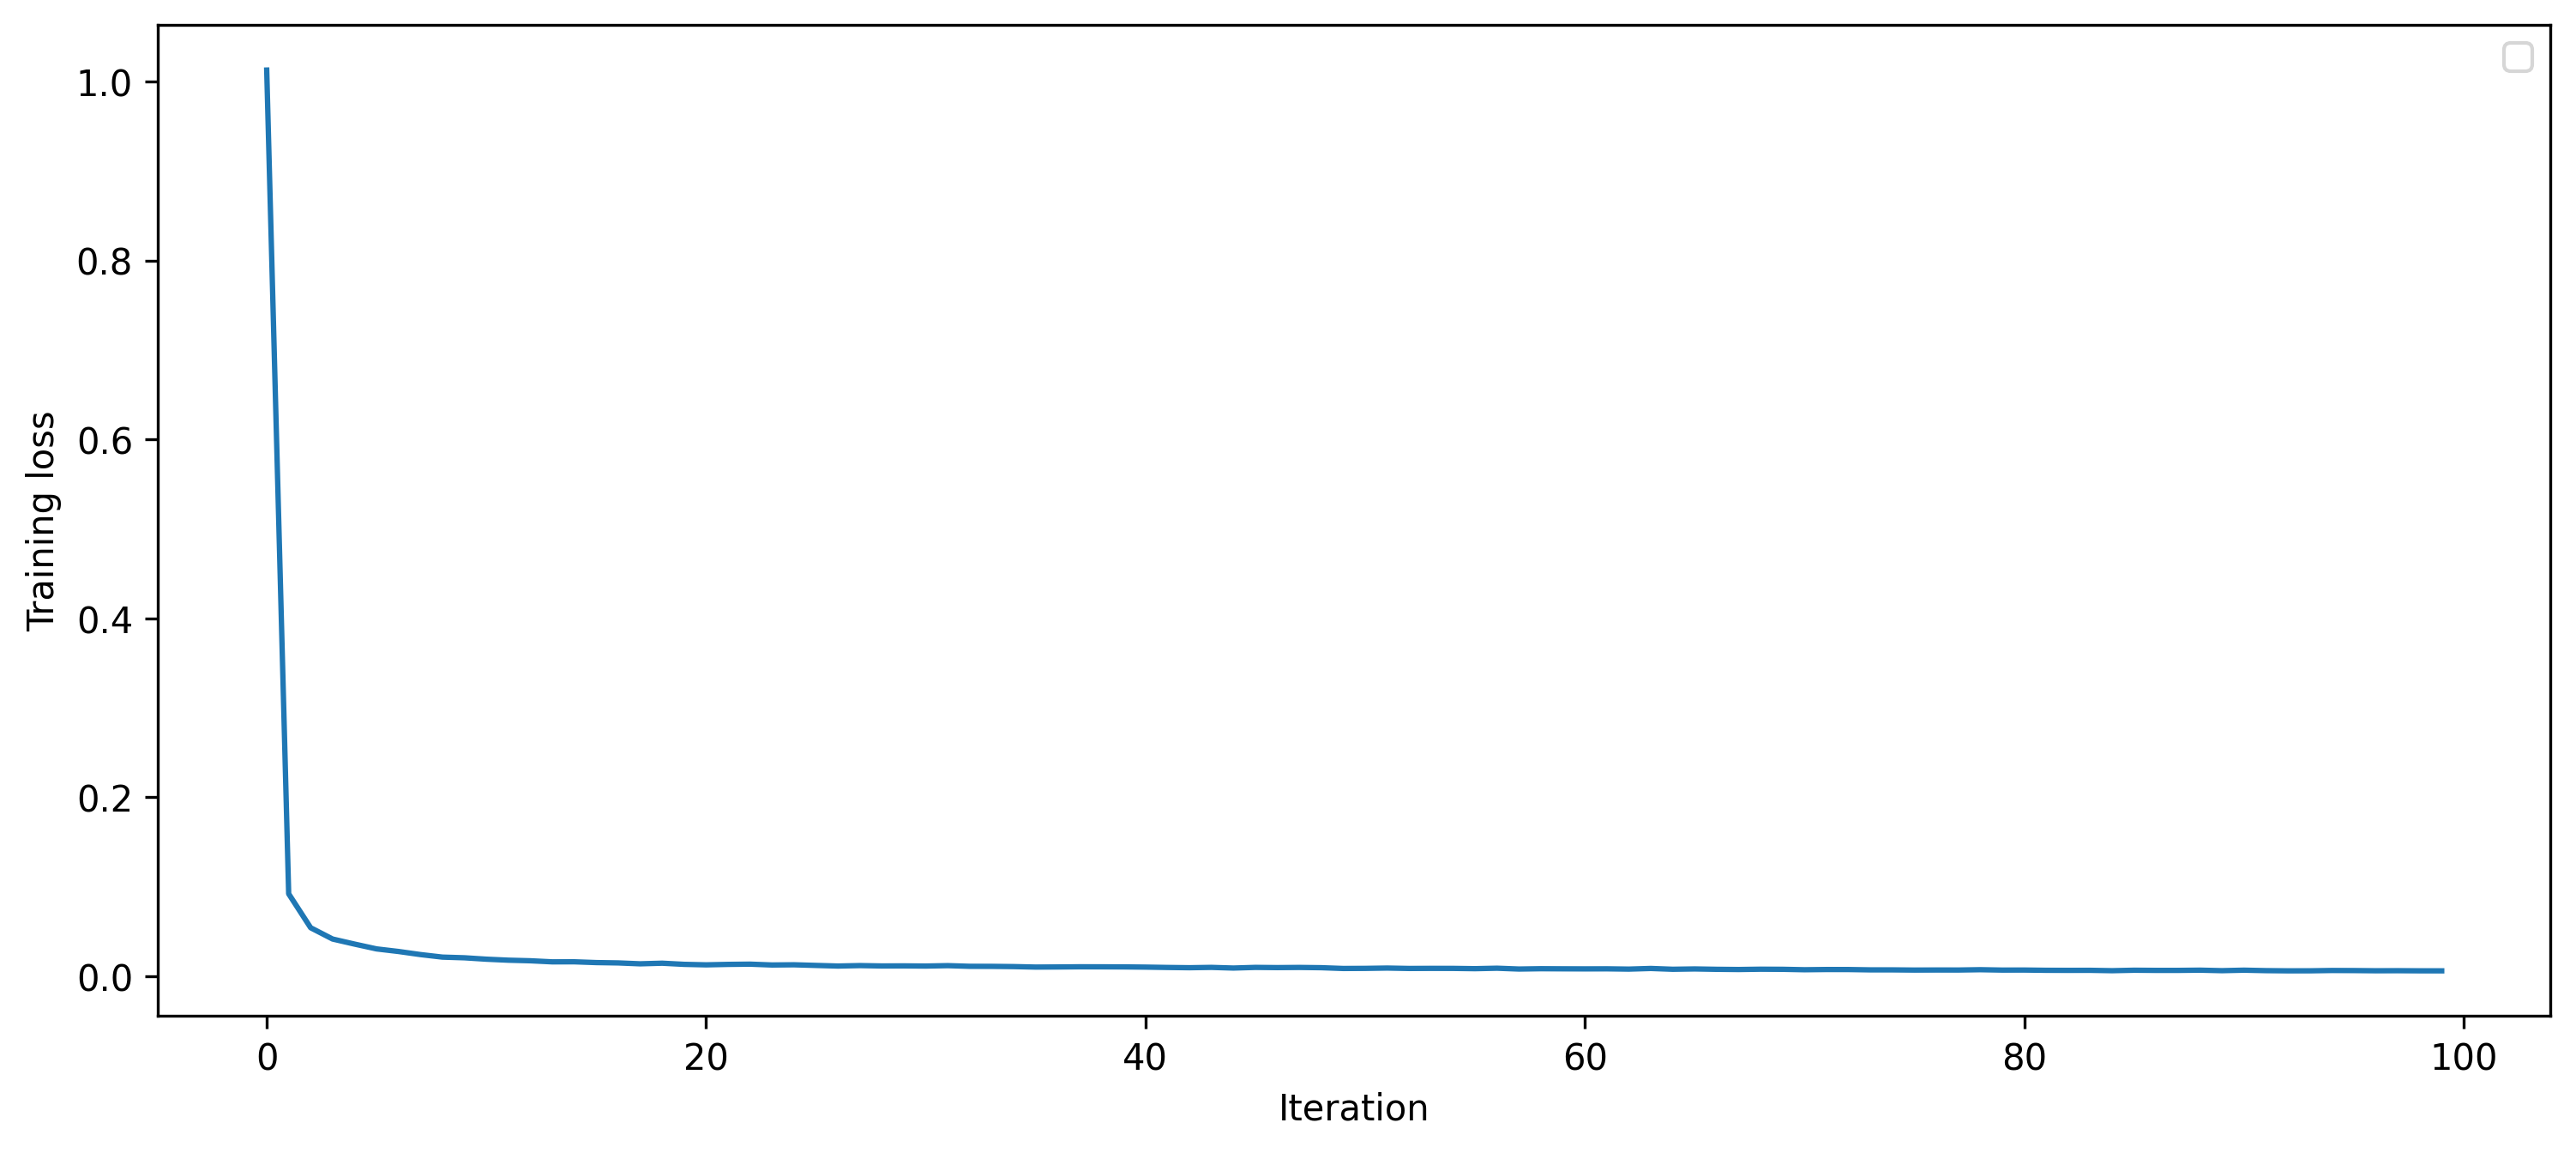

In [10]:
plt.figure(figsize=(12,5), dpi=300)
plt.plot(range(len(Loss_train)), Loss_train)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.legend()

In [11]:
torch.save(model.state_dict(), './result/model/MLP.pth')

In [12]:
model.to("cpu")
def getTestdata(X, FaultDuration = 30):
    if FaultDuration<30 or FaultDuration > 500:
        raise ValueError("Fault Duration out of range.")
    return X[FaultDuration - 30]

x_test = getTestdata(X, FaultDuration=125)
x0_test = x_test[0]
x_test_hat =odeint(model, x0_test, t, method='dopri5', atol=1e-6).detach()

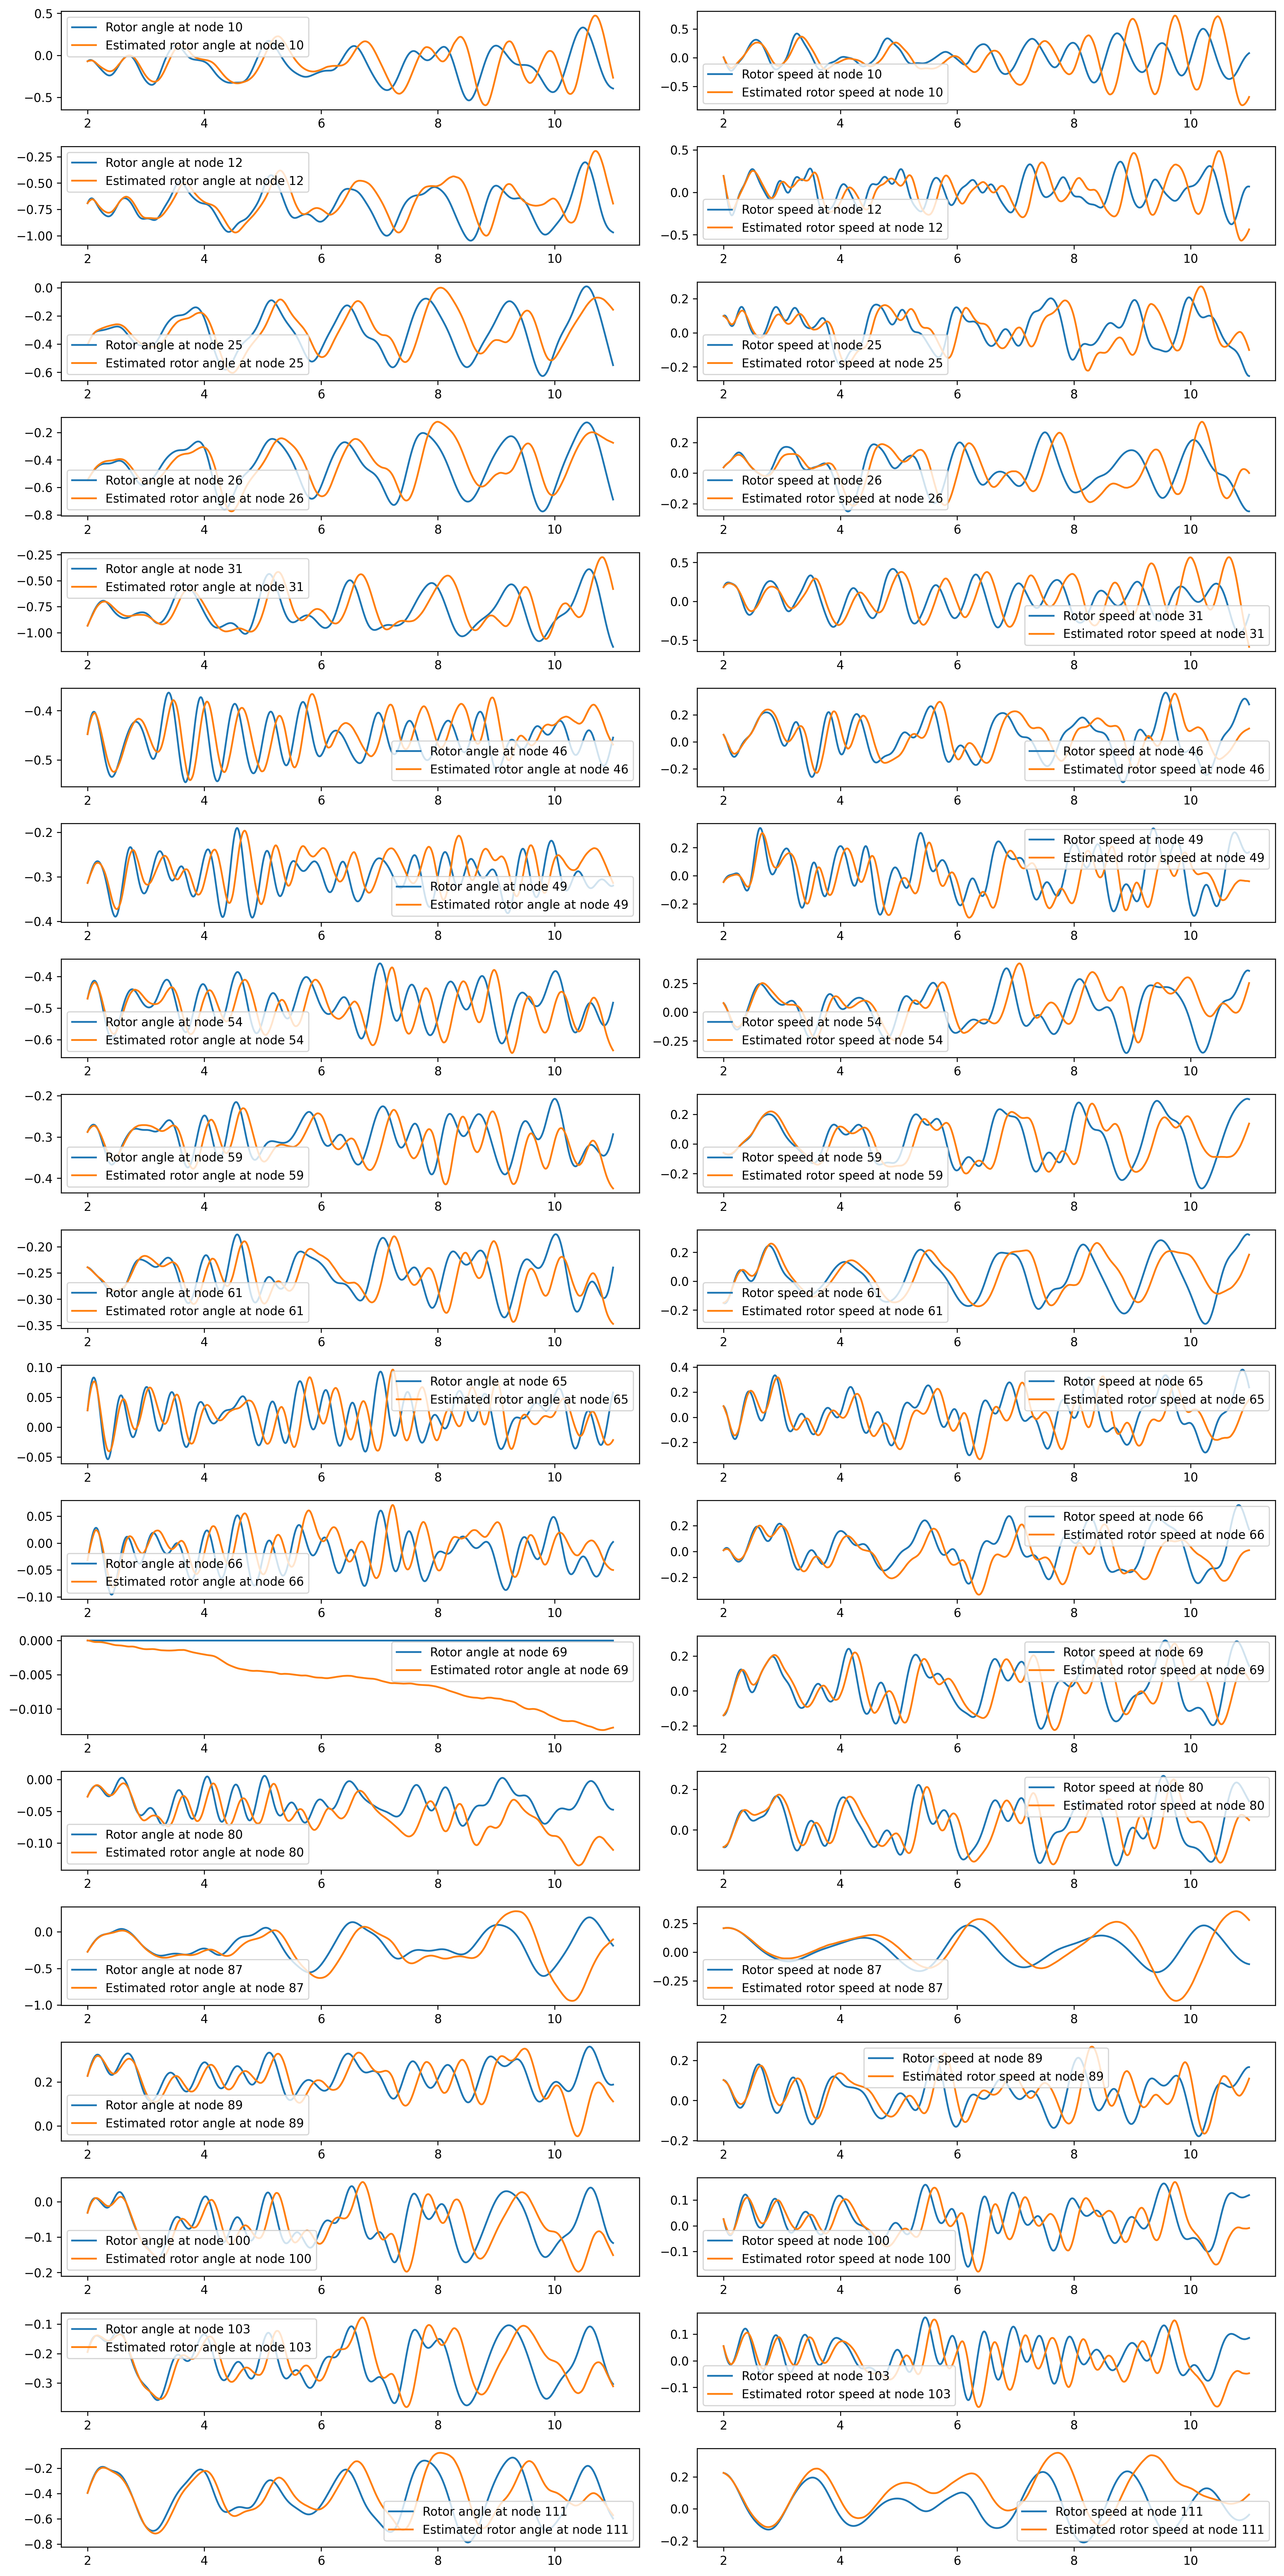

: 

In [13]:
plt.figure(figsize=(15,30),dpi=300)
Generator_nodes = [10, 12, 25, 26, 31, 46, 49, 54, 59, 61, 65, 66, 69, 80, 87, 89, 100, 103, 111]
for i, node in enumerate(Generator_nodes):
    plt.subplot(19,2,2 * i + 1)
    plt.plot(t, x_test[:,2 * i], label="Rotor angle at node {}".format(node))
    plt.plot(t, x_test_hat[:,2 * i], label="Estimated rotor angle at node {}".format(node))
    plt.legend()
    plt.subplot(19,2,2 * i + 2)
    plt.plot(t, x_test[:,2 * i + 1], label="Rotor speed at node {}".format(node))
    plt.plot(t, x_test_hat[:,2 * i + 1], label="Estimated rotor speed at node {}".format(node))
    plt.legend()
plt.tight_layout()